### Modeling

In [188]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import xgboost as xgb


from simple_colors import *
pd.set_option('display.max_columns', None) # Unlimited.

import warnings
warnings.filterwarnings("ignore")

import sys
import sklearn.neighbors._base 
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

import sqlite3

RANDOM_STATE = 42

In [2]:
PALETTE = sns.color_palette("Set2")
sns.set_theme(
    font_scale=1,
    font='arial',
    palette=sns.set_palette(sns.color_palette(PALETTE, as_cmap=False)),
    rc={'figure.figsize':(20,10)},
    )

In [3]:
conn = sqlite3.connect("data_base/test.db") 

In [169]:
sql_select_columns = '''

                SELECT 
                --from ACCIDENT table
                    severity,
                    --accidentdate,
                    --accidenttime,
                    accident_type,
                    day_of_week,
                    light_condition,
                    no_persons,
                    --no_persons_killed,
                    road_geometry,
                    speed_zone,
                    
                --from ACCIDENT_EVENT table
                    --event_type,
                    object_type,
                    
                    
                --from ATMOSPHERIC_COND table
                    atmosph_cond,
                    
                    
                --from PERSON table
                    --sex,
                    --age_group,
                    --seating_position,
                    helmet_belt_worn,
                    road_user_type,
                    
                --from ROAD_SURFACE_COND table
                    surface_cond,
                    
                --from VEHICLE table
                    vehicle_year_manuf,
                    road_surface_type,
                    vehicle_type
                    
                FROM 
                    ACCIDENT as a
                JOIN 
                    ACCIDENT_EVENT as ae      ON a.accident_no = ae.accident_no
                JOIN
                    ATMOSPHERIC_COND as ac    ON a.accident_no = ac.accident_no
                JOIN
                    PERSON as p               ON a.accident_no = p.accident_no
                JOIN
                    ROAD_SURFACE_COND as rsc  ON a.accident_no = rsc.accident_no
                JOIN 
                    VEHICLE as v              ON a.accident_no = v.accident_no
                    
    
            
             '''
df_coordinates = pd.read_sql(sql_select_columns, conn)

In [170]:
df_selected_columns = pd.read_sql(sql_select_columns, conn)

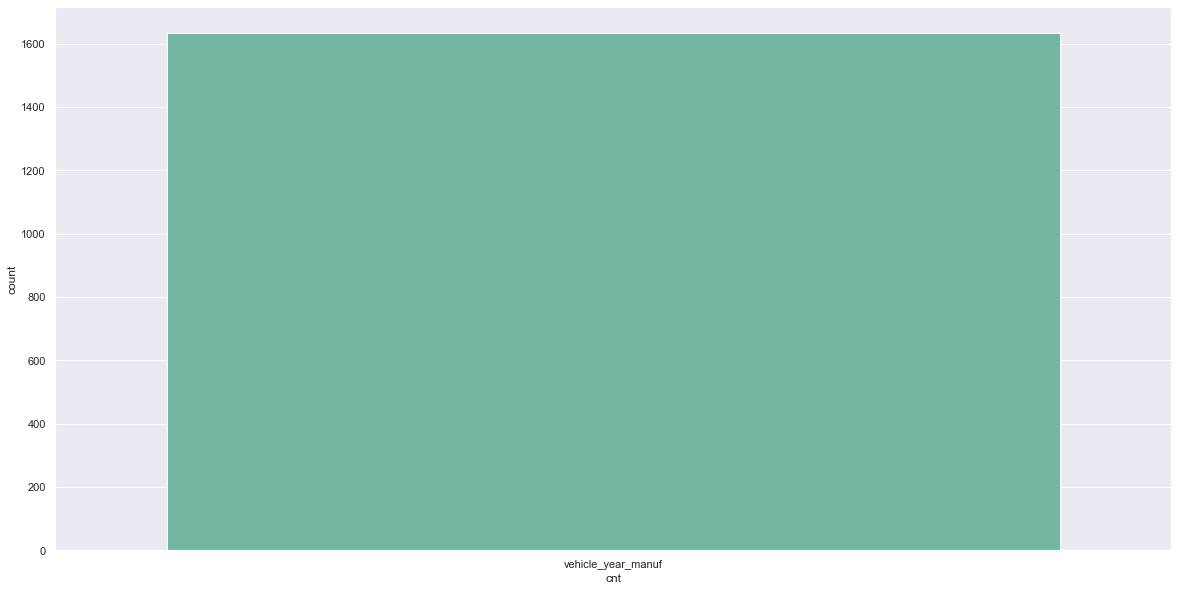

In [171]:
data = pd.DataFrame({'cnt': list(itertools.chain(*[[row['index']] * row['cnt'] for idx, row in df_selected_columns.isnull().sum().to_frame('cnt').reset_index().iterrows()]))})
sns.countplot(x = 'cnt', data = data)
plt.show()

- accidenttime has few missing values anc can be dropped.
- seating position can be fillen with mean()
- wehickle_year_manuf can be filled with mode()

In [172]:
df = df_selected_columns.copy()

In [173]:
#replace_sp = df.seating_position.value_counts().argmax()
#df['seating_position'].fillna(replace_sp, inplace=True) 

#replace_vym = df.seating_position.value_counts().argmax()
df['vehicle_year_manuf'].fillna(replace_vym, inplace=True) 

In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25003 entries, 0 to 25002
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   severity            25003 non-null  int64  
 1   accident_type       25003 non-null  int64  
 2   day_of_week         25003 non-null  int64  
 3   light_condition     25003 non-null  int64  
 4   no_persons          25003 non-null  int64  
 5   road_geometry       25003 non-null  int64  
 6   speed_zone          25003 non-null  int64  
 7   object_type         25003 non-null  float64
 8   atmosph_cond        25003 non-null  int64  
 9   helmet_belt_worn    25003 non-null  int64  
 10  road_user_type      25003 non-null  int64  
 11  surface_cond        25003 non-null  int64  
 12  vehicle_year_manuf  25003 non-null  float64
 13  road_surface_type   25003 non-null  int64  
 14  vehicle_type        25003 non-null  int64  
dtypes: float64(2), int64(13)
memory usage: 2.9 MB


In [175]:
X = df.iloc[:,1:]
y = df['severity']

In [201]:
#Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=5)

In [202]:
# Normalize Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [203]:
def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred) 

    return model, accuracy

### RandomForestClassifier

In [204]:
params_rf = {'max_depth': 25,
         'min_samples_leaf': 1,
         'min_samples_split': 2,
         'n_estimators': 1200,
         'random_state': 42}

model_rf = RandomForestClassifier(**params_rf)
model_rf, accuracy_rf = run_model(model_rf, X_train, y_train, X_test, y_test)

In [205]:
print('The accuracy: ',accuracy_rf)

The accuracy:  0.9004199160167966


In [206]:
y_pred = model_rf.predict(X_test)

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

In [207]:
cf_matrix

array([[  72,    4,   20,    0],
       [   2, 1445,  308,    0],
       [   2,  160, 2984,    0],
       [   0,    2,    0,    2]])

In [208]:
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cf_matrix,
                     index = [1,2,3,4], 
                     columns = [1,2,3,4])

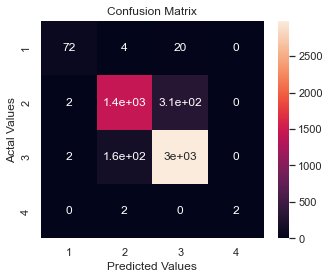

In [209]:
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

From the Confusion Matrix, we see that a majority of the __1 (Fatal accident)__ class is found correct!

Most of the mis labels are labeled as __3 (minor injury accident)__

We can say that that there are strong relations between features and severity of the accidents. 

### Model Feature Importance

Feature: 0, Score: 0.03427
Feature: 1, Score: 0.14827
Feature: 2, Score: 0.04869
Feature: 3, Score: 0.18874
Feature: 4, Score: 0.06960
Feature: 5, Score: 0.11583
Feature: 6, Score: 0.01977
Feature: 7, Score: 0.02699
Feature: 8, Score: 0.03393
Feature: 9, Score: 0.02990
Feature: 10, Score: 0.03055
Feature: 11, Score: 0.16499
Feature: 12, Score: 0.01575
Feature: 13, Score: 0.07274


<AxesSubplot:>

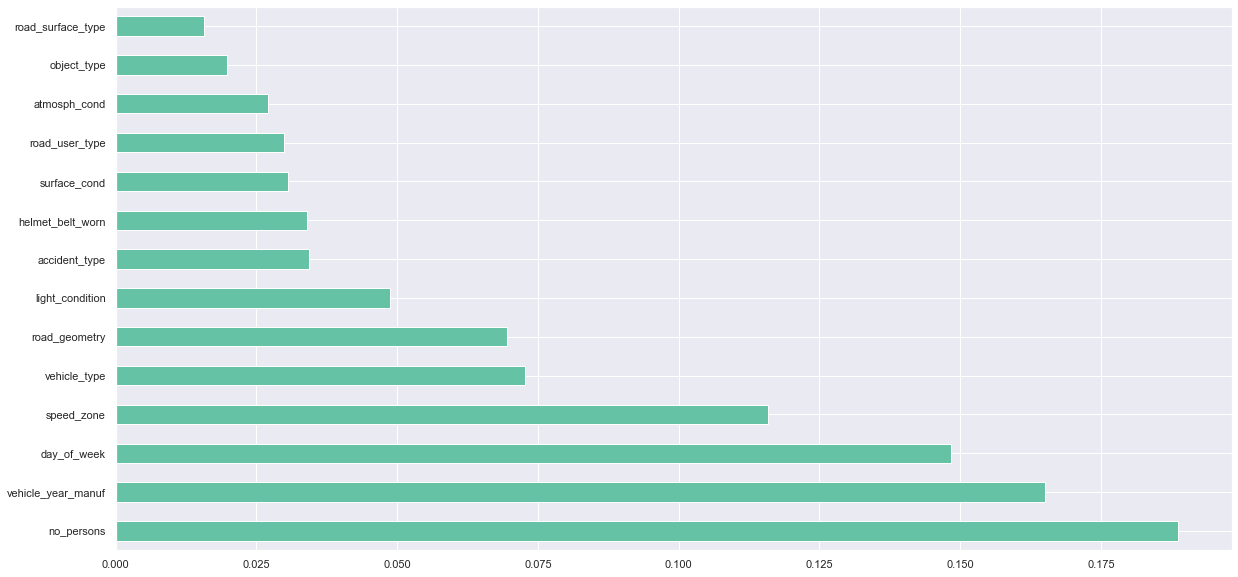

In [185]:
# summarize feature importance
for i,v in enumerate(model_rf.feature_importances_):
    print('Feature: %0d, Score: %.5f' % (i,v))

feat_importances = pd.Series(model_rf.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

__The model feature importance:__

From the graph, we see the order for the feature importance. 

We can consider this as the indicator of the relationships between predictors and target variable.



### Improving Model Performance

What can be tried to improve model performance

    - Encoding data
    - Reducing dimension
    - Hyperparametert tuning
    
It would also be very helpful to do more on Feature Engineering like creating new variables. 

### Conclusion

We trained RandomForest the data with the selected columns and plot the confusion matrix.

From the confusion matrix we see that 1 leve injuries have a high accuracy to be found.  

From the feature importance graph we see that the relavance is listed as:

- number of people involved, 
- the production year of vehicle, 
- day of week, 
- speed zone 

It is important to see the cars and roads are the biggest effect on causing the level of the injury. 


__Note__: Further Steps for Improvement:

    - Missing Values can be handled with more advance techniques like using K-Means or Hierarchical clustering to predict missing values. 
    - Different search methods can be used for hyperparameter tunning
    - More can be done on Feature Engineering like creating new and relevant features.

